In [16]:
import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
mjd=[]
for i in range(1, 25):
    hdul=fits.open(f'UVB_{i:02}.fits')
    mjd.append(hdul[0].header['MJD-OBS'])
print(mjd)

[60555.028221625, 60555.035851886, 60555.043486314, 60555.05111403, 60555.058745331, 60555.066376633, 60555.074008166, 60555.084229149, 60555.091863807, 60555.099495802, 60555.139454998, 60555.14708572, 60555.154719451, 60555.162352026, 60555.169984947, 60555.17761949, 60555.185252758, 60555.227759841, 60555.235393223, 60555.243026604, 60555.25066068, 60555.258291978, 60555.265922003, 60555.273555848]


In [17]:
ltt_barylist=[]
jpllist=[]
for i in range (1, 25):
    hdul=fits.open(f'UVB_{i:02}.fits')
    from astropy import time, coordinates as coord, units as u
    UVB = coord.SkyCoord("21:21:18.6", "-09:43:29.0",
                        unit=(u.hourangle, u.deg), frame='icrs')
    paranal = coord.EarthLocation.of_site('paranal')
    times = time.Time([mjd[i-1]+((hdul[0].header['EXPTIME']/2) / 86400.0)], format='mjd',
                  scale='utc', location=paranal)
    ltt_bary = times.light_travel_time(UVB)
    ltt_barylist.append(ltt_bary)

numbers_in_days = [i.value.item() for i in ltt_barylist]
print(numbers_in_days) #correction for light travel time in days

[0.0054368503758624506, 0.0054365905360851995, 0.005436330045381751, 0.005436069261531832, 0.005435807820130249, 0.005435545831924733, 0.005435283278383141, 0.005434930748314268, 0.005434666747297473, 0.005434402253251786, 0.005433007699305625, 0.005432739516984444, 0.0054324706281000355, 0.005432201181821184, 0.0054319311290700325, 0.005431660429486963, 0.005431389191915763, 0.005429868491483635, 0.005429593651305446, 0.005429318310050885, 0.005429042457724709, 0.005428766236101041, 0.005428489608024792, 0.0054282124064122675]


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SpectralCoord
sc_nm_list = []
for i in range(1, 25):
    file = f'UVB_{i:02}.fits'
    hdul = fits.open(file)
    flux_data = hdul[0].data
    header = hdul[0].header
    start_wavelength_nm = header['CRVAL1']
    wavelength_step_nm = header['CDELT1']
    pixel_axis = np.arange(len(flux_data))
    wavelength_nm = start_wavelength_nm + (pixel_axis * wavelength_step_nm)
    sc = SpectralCoord(wavelength_nm, unit='nm')
    sc_nm_list.append(sc)
    #spectral coord for UVB in nm

In [19]:
from astropy.constants import c

barycorrlist=[]
bjdlist=[]
for i in range (1, 25):
    file = f'UVB_{i:02}.fits'
    hdul = fits.open(file)
    from astropy import time, coordinates as coord, units as u
    UVB = coord.SkyCoord("21:21:18.6", "-09:43:29.0", unit=(u.hourangle, u.deg), frame='icrs')
    paranal = coord.EarthLocation.of_site('paranal')
    times = time.Time([mjd[i-1]+((hdul[0].header['EXPTIME']/2) / 86400.0)], format='mjd', scale='utc', location=paranal)
    barycorr = UVB.radial_velocity_correction(obstime=times)
    barycorrlist.append(barycorr)
    ltt_bary = times.light_travel_time(UVB)
    ltt_barylist.append(ltt_bary)
    time_barycentre = times.tdb + ltt_bary.value.item()
    bjdlist.append(time_barycentre)
#bjdlist is the BMJD (time) of observation corrected for light travel time and relativity effects etc.

bary_nmlist=[]
for i in range (1, 25):
    bary_nm = sc_nm_list[i-1].with_radial_velocity_shift(barycorrlist[i-1])
    bary_nmlist.append(bary_nm)
#bary_nmlist is the wavelength shifted spectra

In [20]:
def orbitalphasefunc():
    T0_val = 59385.541376
    P = 0.0953979016
    T0 = time.Time(T0_val, format='mjd', scale='tdb')
    orbitalphase = [float(np.mod((btime - T0).value / P, 1)) for btime in bjdlist]
    return orbitalphase

In [21]:
final_params=[ 3.76788011e+01 , 4.53658700e+01 ,-4.17207264e-01,  5.02974774e+01,
  1.98337287e+01 , 3.33838906e+02 , 4.37246818e-01,  2.38910124e+01,
 -1.79325494e-05,  1.13647558e+00] 
gamma_wd=final_params[0]
k_wd=final_params[1]
orbitalphase=orbitalphasefunc()
restframe_nmlist=[]
for i, phase in enumerate(orbitalphase):
    bary_corrected_sc = bary_nmlist[i]
    v_obs_wd = gamma_wd - k_wd * np.sin(2 * np.pi * phase)
    v_correction = -v_obs_wd * (u.km / u.s)
    
    # Apply the shift to create the rest-frame wavelength axis
    restframe_nm = bary_corrected_sc.with_radial_velocity_shift(v_correction)
    restframe_nmlist.append(restframe_nm)    
print(restframe_nmlist)

[<SpectralCoord 
   (observer to target:
      radial_velocity=[-12.4385714] km / s
      redshift=[-4.14897475e-05])
  [298.90759788, 298.92759705, 298.94759623, ..., 555.91693419,
   555.93693336, 555.95693253] nm>, <SpectralCoord 
   (observer to target:
      radial_velocity=[-3.19553469] km / s
      redshift=[-1.06590996e-05])
  [298.91681378, 298.93681357, 298.95681336, ..., 555.93407418,
   555.95407397, 555.97407375] nm>, <SpectralCoord 
   (observer to target:
      radial_velocity=[-5.0095135] km / s
      redshift=[-1.67097988e-05])
  [298.91500511, 298.93500477, 298.95500444, ..., 555.93071035,
   555.95071002, 555.97070969] nm>, <SpectralCoord 
   (observer to target:
      radial_velocity=[-17.42936191] km / s
      redshift=[-5.81364034e-05])
  [298.90262187, 298.9226207 , 298.94261954, ..., 555.90767965,
   555.92767849, 555.94767732] nm>, <SpectralCoord 
   (observer to target:
      radial_velocity=[-37.39813514] km / s
      redshift=[-0.00012474])
  [298.88271303, 

/tmp/ipykernel_142021/2926889284.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  orbitalphase = [float(np.mod((btime - T0).value / P, 1)) for btime in bjdlist]


The median of the 24 individual median fluxes is: 1.1627882389182161e-16


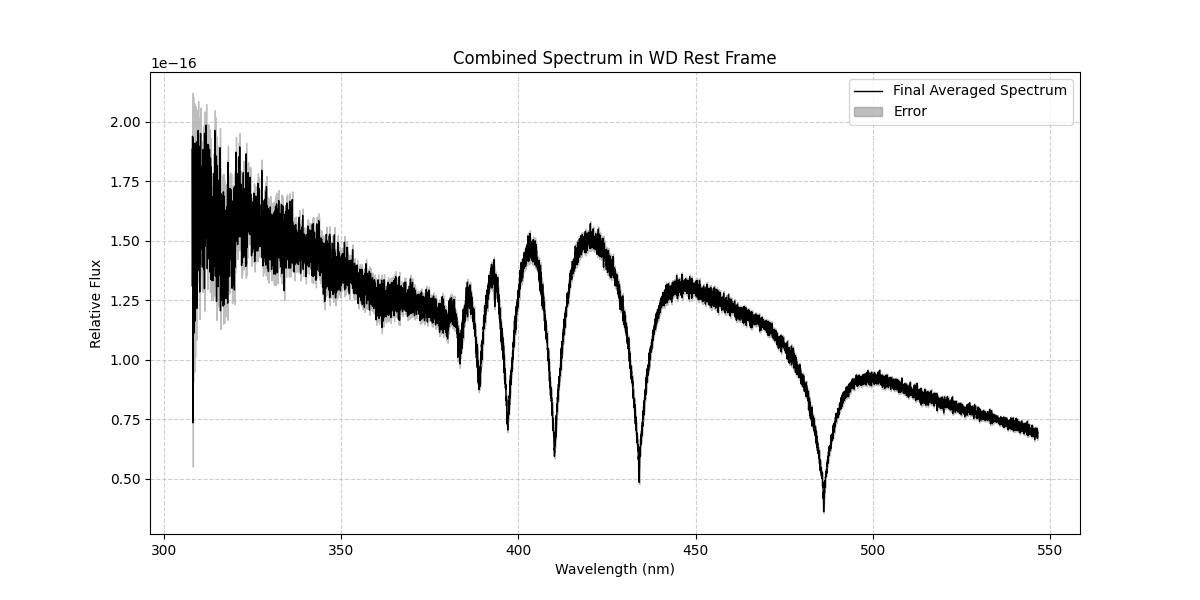

In [35]:
import scipy
import pandas as pd
from astropy.stats import sigma_clip
import numpy.ma as ma
%matplotlib widget
common_wavelength_axis_nm = np.arange(308.0, 546.5, 0.02)
resampled_flux_list = []
file_list = [f'UVB_{i:02}.fits' for i in range(1, 25)]

n_mc = 200  # Number of Monte Carlo simulations

# These lists will store the results for each of the 21 spectra
list_of_mean_fluxes = []
list_of_flux_errors = []

for i, fitfile in enumerate(file_list):
    with fits.open(fitfile) as hdul:
        flux_data = hdul[0].data
        flux_error = hdul[1].data
    
    simulated_fluxes = np.random.normal(
        loc=flux_data, 
        scale=flux_error, 
        size=(n_mc, len(flux_data)))
    
    resampled_simulations = []
    for j in range(n_mc):
        f = scipy.interpolate.interp1d(
            restframe_nmlist[i].value, 
            simulated_fluxes[j, :],
            kind='cubic', 
            bounds_error=False, 
            fill_value=np.nan)
        resampled_simulations.append(f(common_wavelength_axis_nm))
    
    resampled_per_spectrum = np.array(resampled_simulations)
    
    mean_flux = np.nanmean(resampled_per_spectrum, axis=0)
    std_dev_flux = np.nanstd(resampled_per_spectrum, axis=0)
    
    # Append the results to our master lists
    list_of_mean_fluxes.append(mean_flux)
    list_of_flux_errors.append(std_dev_flux)


resampled_flux_array = np.array(list_of_mean_fluxes)
resampled_error_array = np.array(list_of_flux_errors) 

median_fluxes = []
normalised_flux_list = []
normalised_error_list = [] 

for i in range(len(resampled_flux_array)):
    flux_spectrum = resampled_flux_array[i]
    error_spectrum = resampled_error_array[i]
    
    median_val = np.nanmedian(flux_spectrum)
    median_fluxes.append(median_val)

    # Normalise flux and store the result
    normalised_flux = flux_spectrum / median_val
    normalised_flux_list.append(normalised_flux)
    
    # Propagate the error for the normalization
    normalised_error = error_spectrum / median_val
    normalised_error_list.append(normalised_error)

normalised_flux_array = np.array(normalised_flux_list)
normalised_error_array = np.array(normalised_error_list) 

#---modification---
clipped_flux_array = sigma_clip(normalised_flux_array, sigma=3, maxiters=5, axis=0)

# Calculate the average flux using the median 
average_normalised_flux = ma.median(clipped_flux_array, axis=0).data

# Apply the exact same mask from the flux clipping to the error array.
# This ensures that if a flux value was rejected, its error is also rejected.
masked_error_array = ma.array(normalised_error_array, mask=clipped_flux_array.mask)

# recalculate the error on the mean using only the un-masked values.
# This is the standard formula for combining errors: sqrt(sum of variances) / N
sum_of_variances = ma.sum(masked_error_array**2, axis=0).data
N_clipped = clipped_flux_array.count(axis=0)

error_on_average_normalised_flux = np.sqrt(sum_of_variances) / N_clipped

# Take the median of the 21 individual median fluxes
median_of_medians = np.nanmedian(median_fluxes)

# Create the final spectrum by re-scaling the average
final_average_spectrum = average_normalised_flux * median_of_medians

# Scale the propagated error by the same median factor
final_spectrum_error = error_on_average_normalised_flux * median_of_medians

print(f"The median of the 24 individual median fluxes is: {median_of_medians}")

plt.figure(figsize=(12, 6))
plt.plot(common_wavelength_axis_nm, final_average_spectrum, label='Final Averaged Spectrum', color='black', linewidth=1)
plt.fill_between(
    common_wavelength_axis_nm,
    final_average_spectrum - final_spectrum_error,
    final_average_spectrum + final_spectrum_error,
    color='gray', alpha=0.5, label='Error'
)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Relative Flux')
plt.title('Combined Spectrum in WD Rest Frame')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [38]:
final_spectrum = pd.DataFrame({
    'wavelength_nm': common_wavelength_axis_nm,
    'flux': final_average_spectrum,
    'flux_error': final_spectrum_error
})

output_filename_csv = 'UVB_final_spectrum_with_errors(v3).csv'

# Save the DataFrame to a CSV file
# index=False prevents pandas from writing the DataFrame index as a column
final_spectrum.to_csv(output_filename_csv, index=False, float_format='%.8e')
